Bole 95th Percentile: 38.1
Navrongo 95th Percentile: 41.0
Wa 95th Percentile: 39.0
Walewale 95th Percentile: 40.3
Yendi 95th Percentile: 39.4


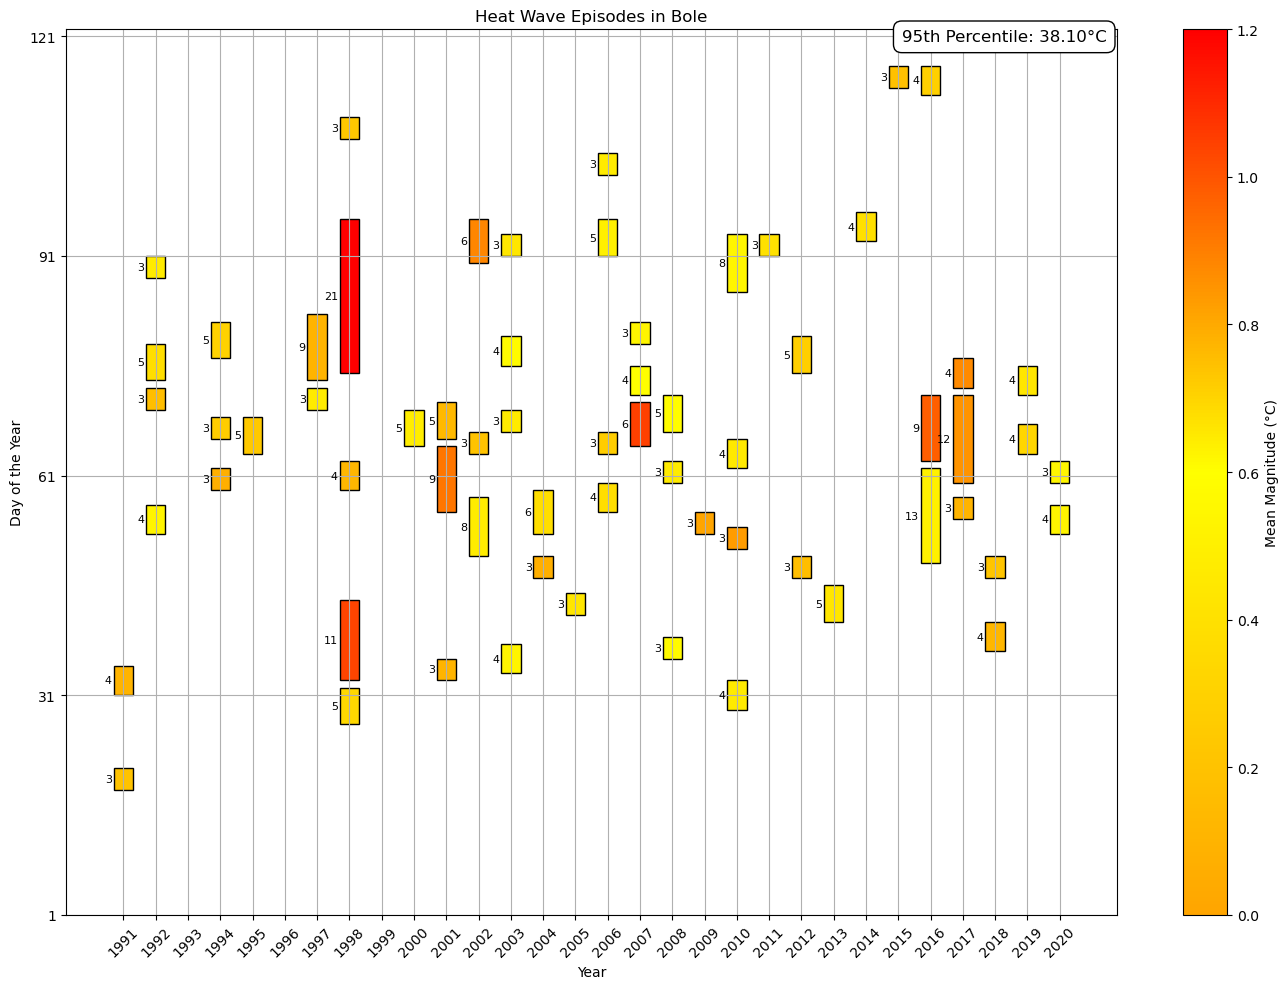

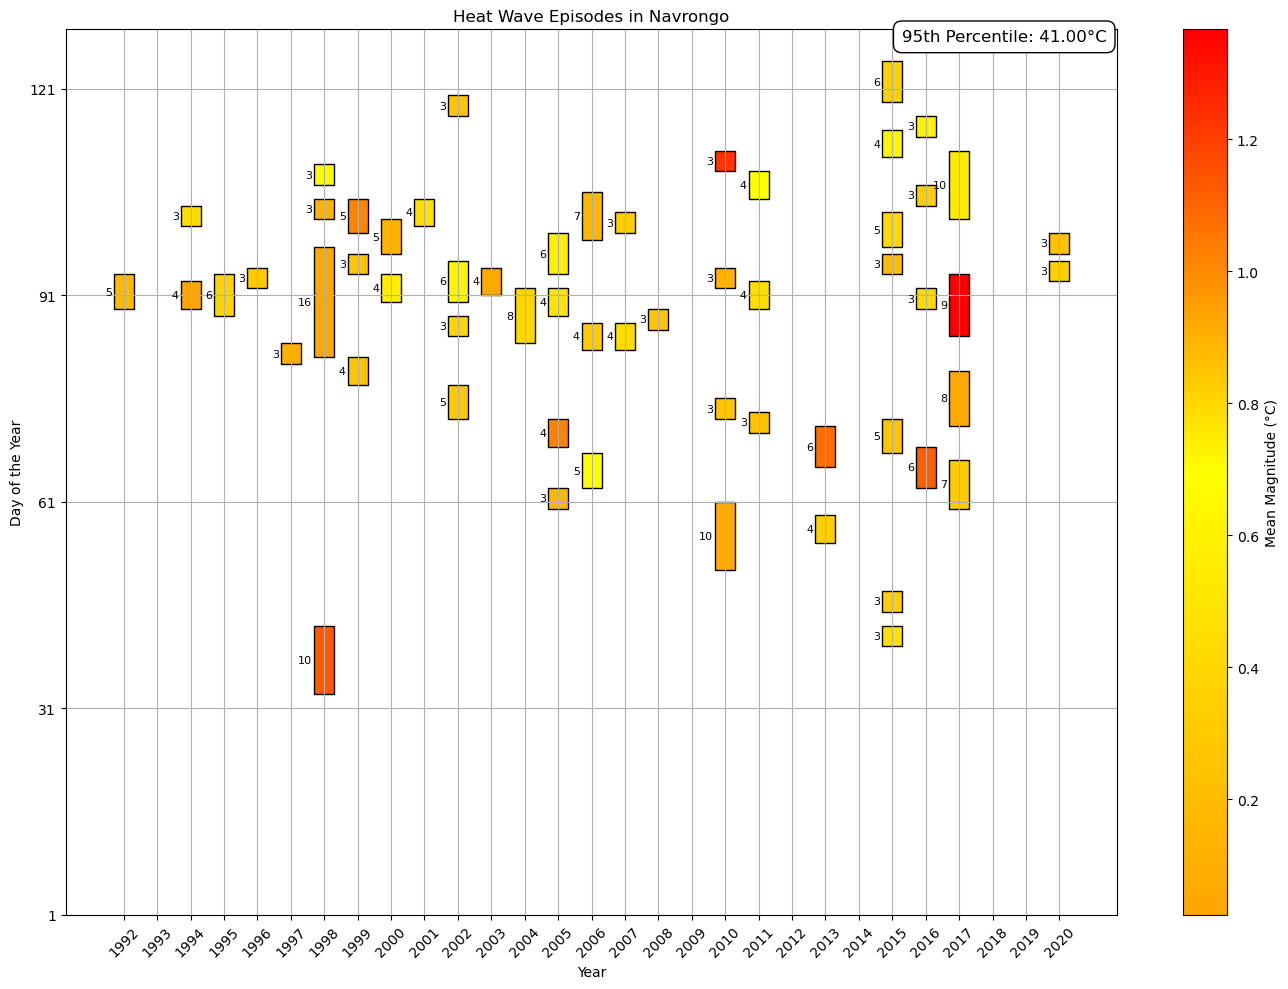

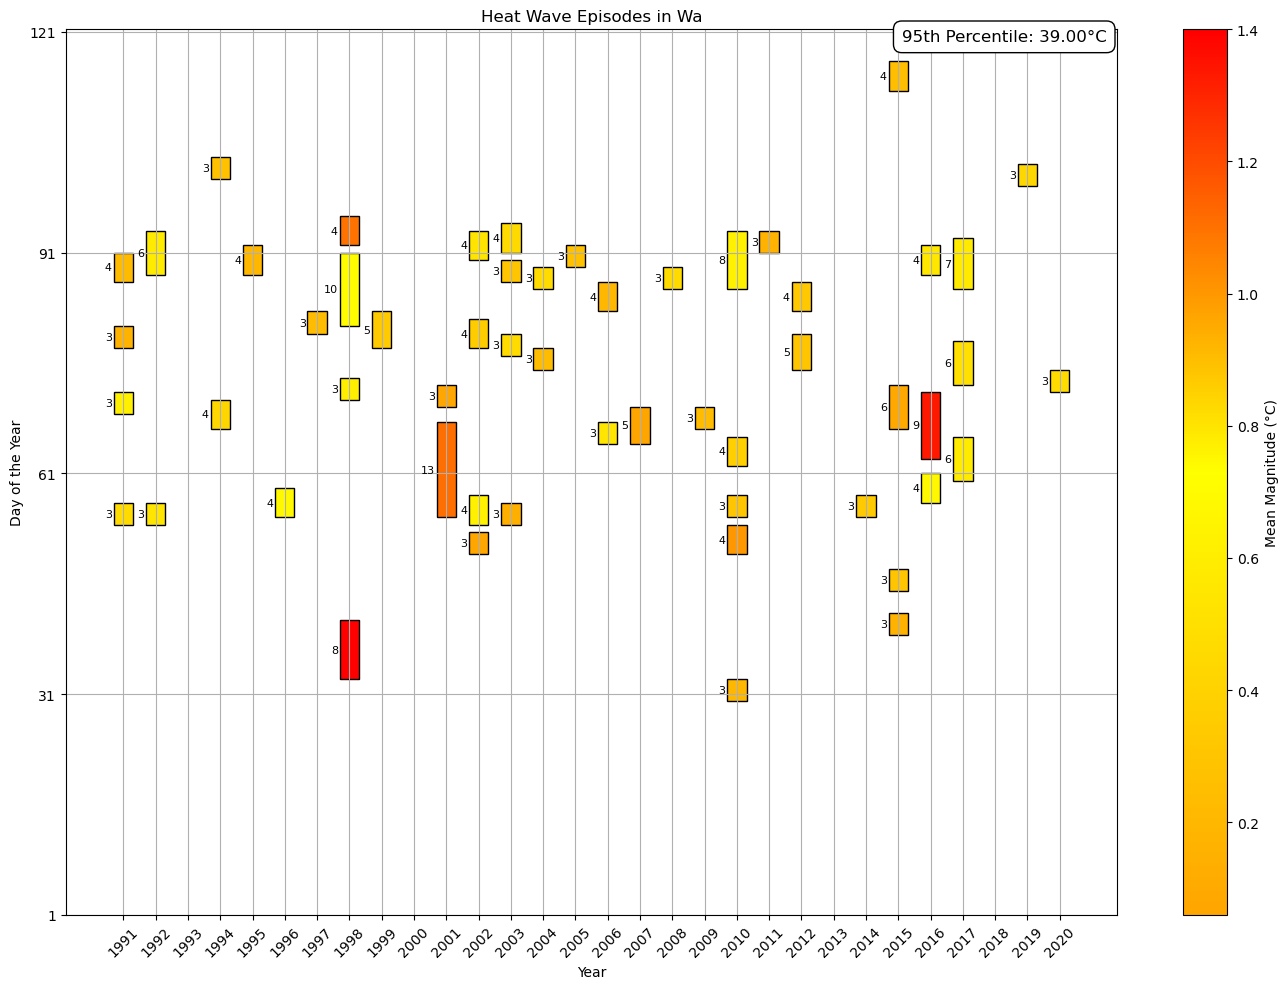

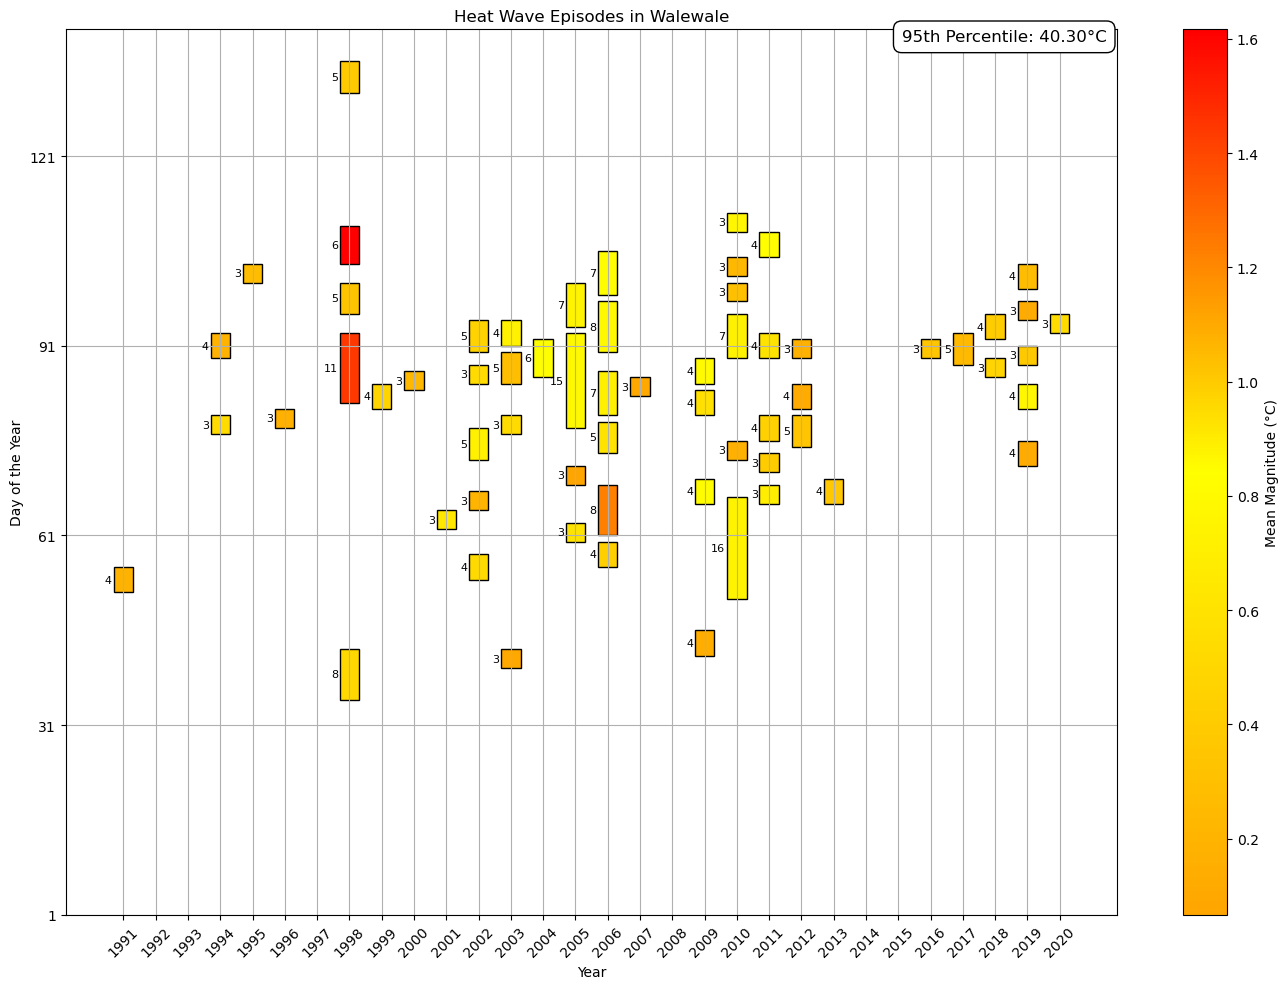

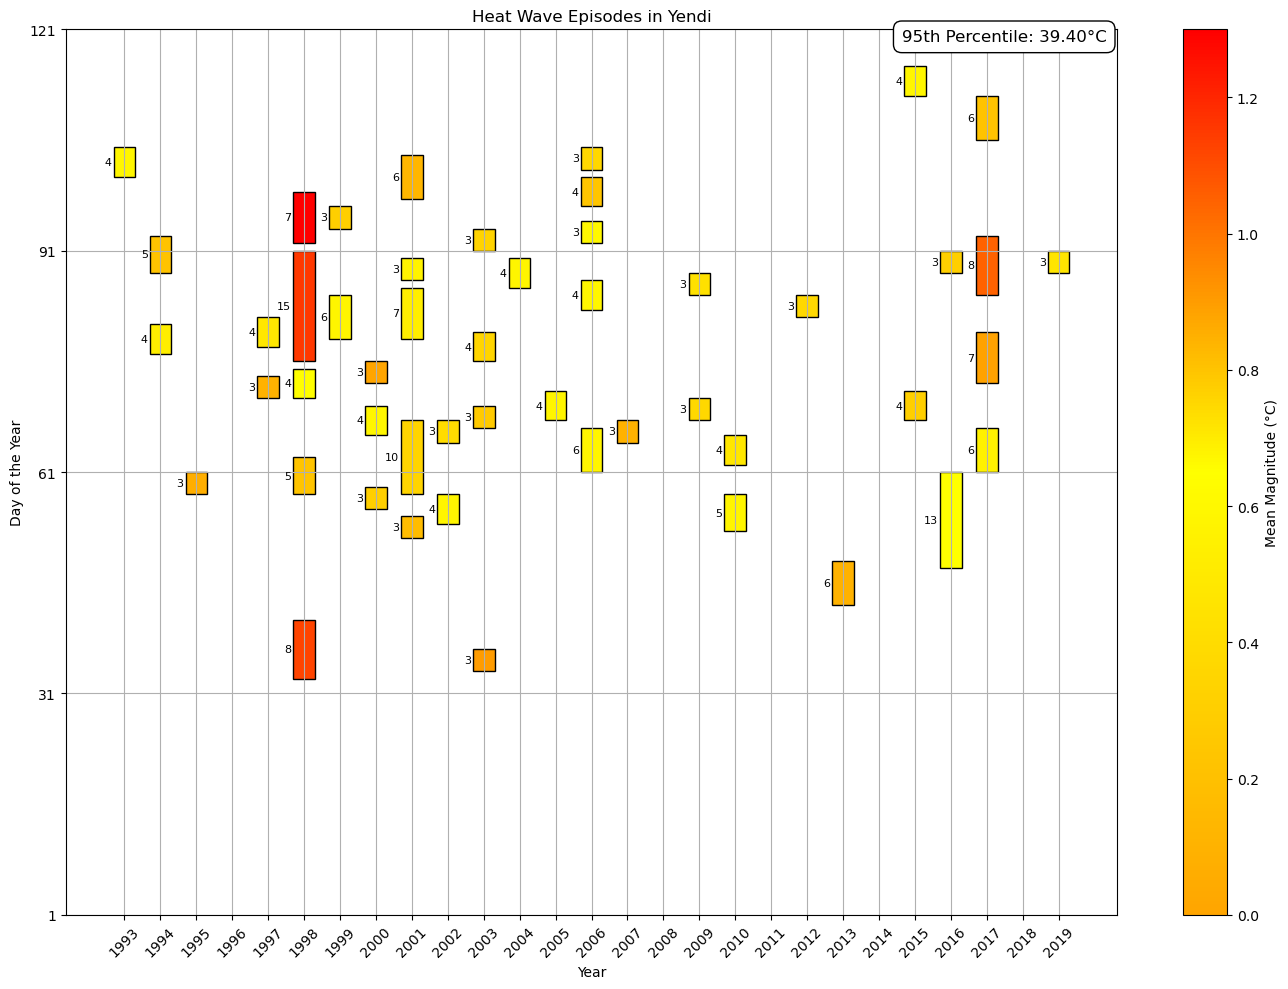

<Figure size 640x480 with 0 Axes>

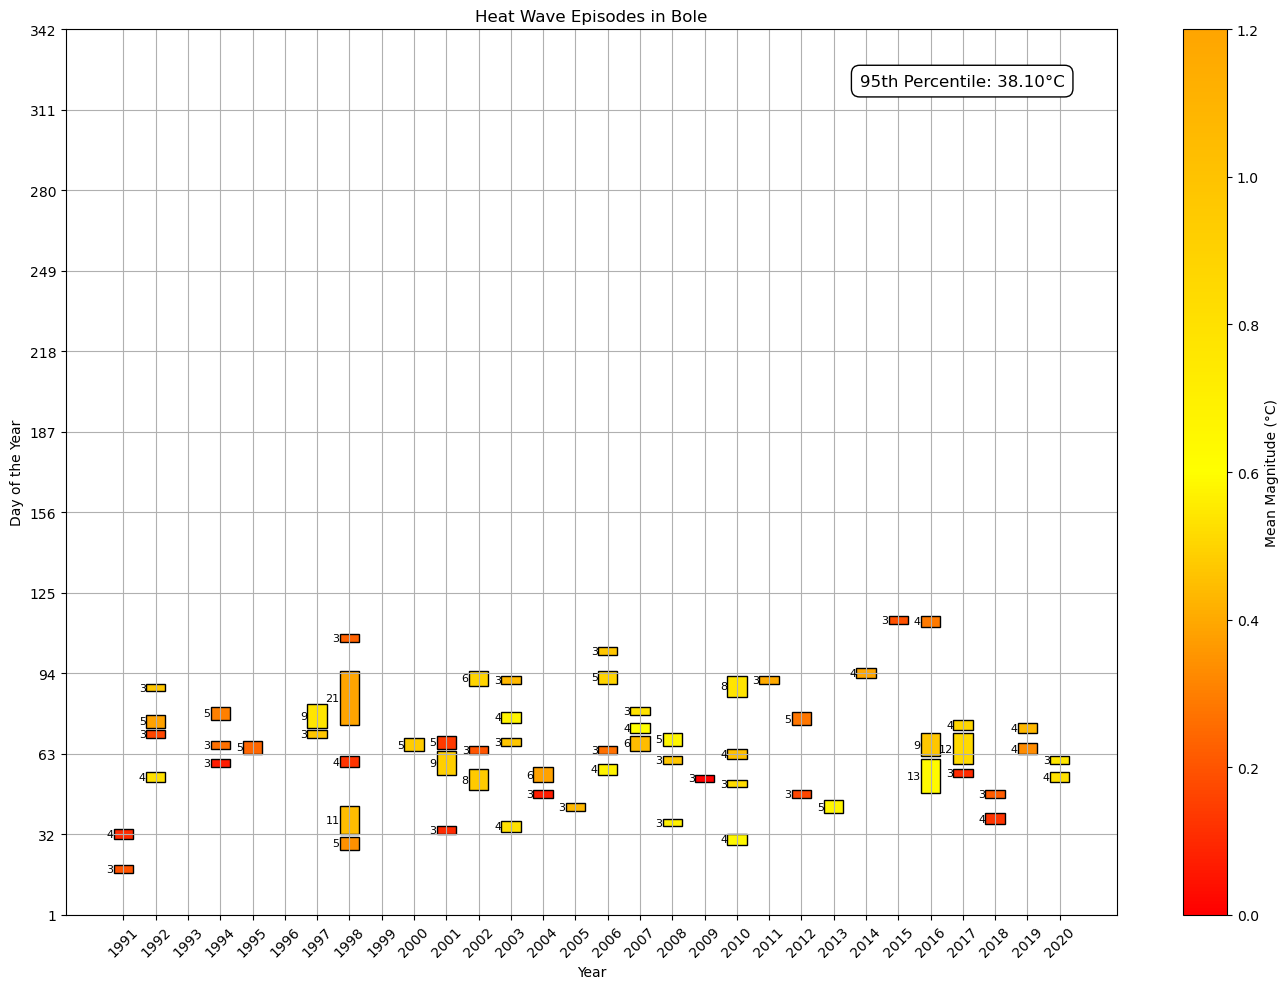

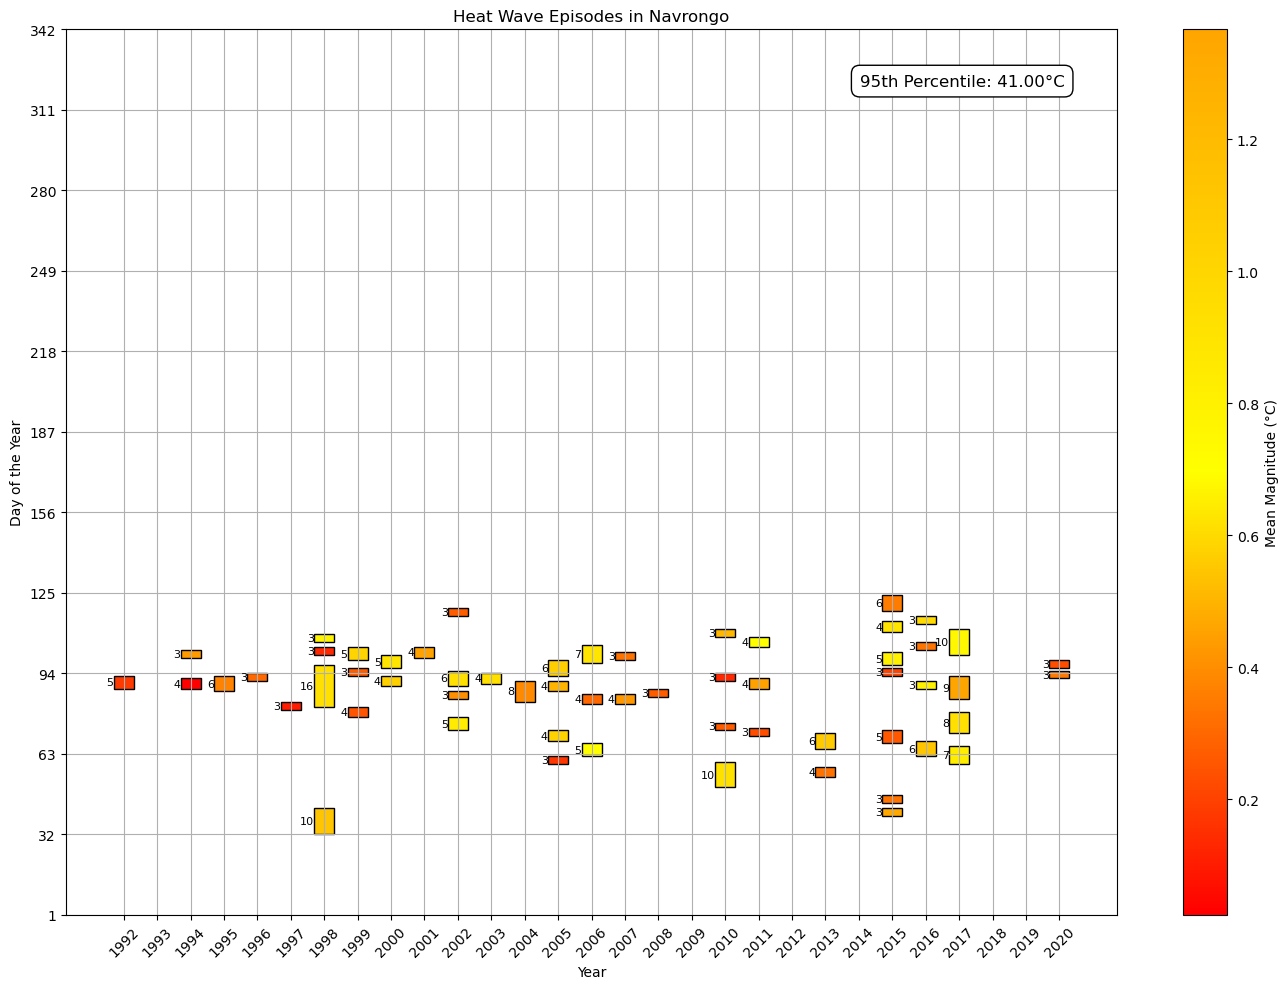

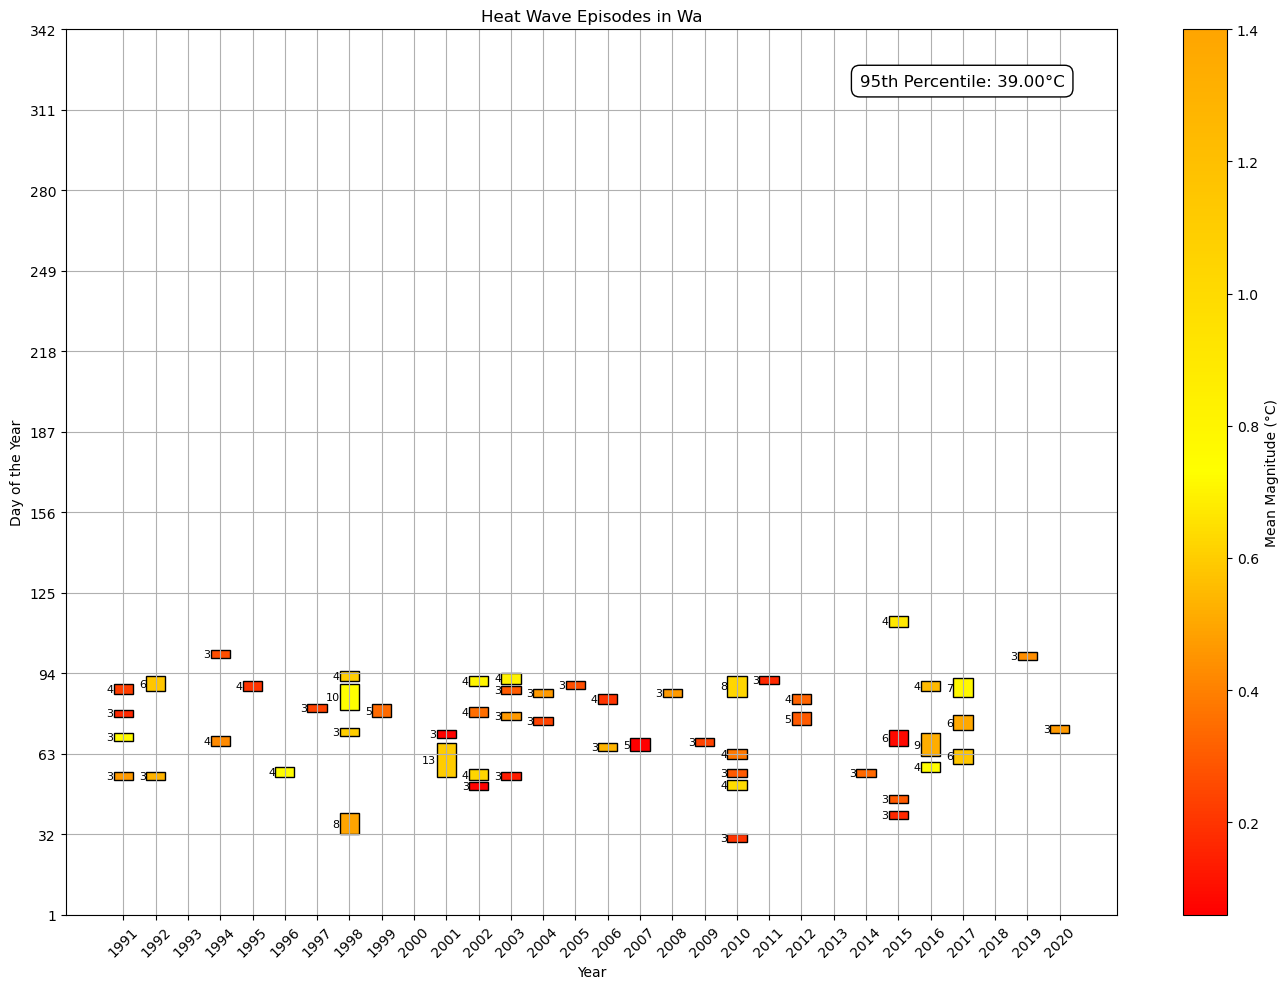

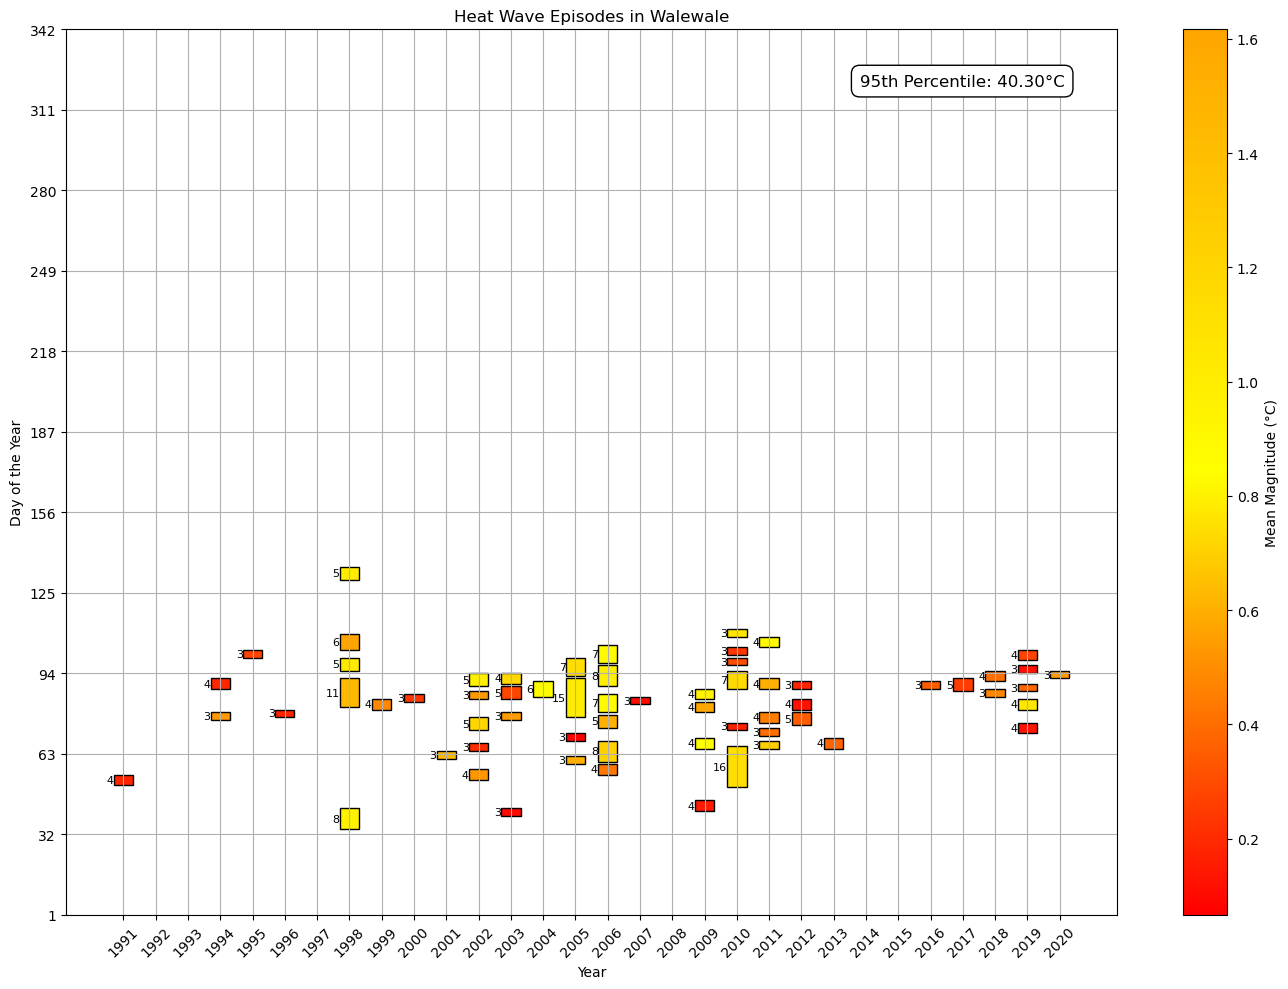

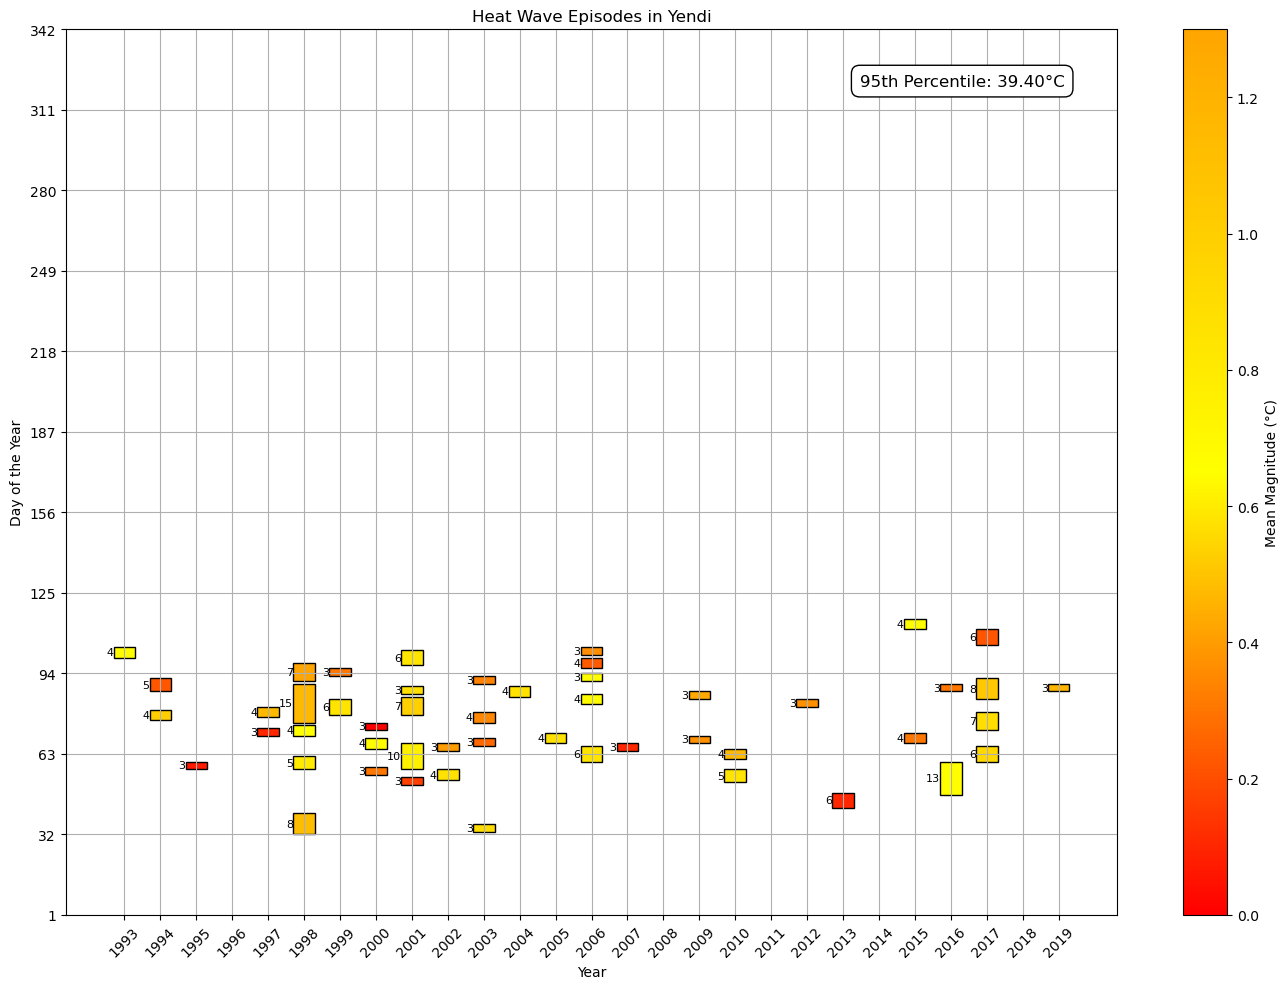

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable 
from matplotlib.colors import Normalize, LinearSegmentedColormap
# Loading the data
Bole = pd.read_csv('Bole_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Navrongo = pd.read_csv('Navrongo_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Wa = pd.read_csv('Wa_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Walewale = pd.read_csv('Walewale_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Yendi = pd.read_csv('Yendi_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]

# 90th percentile for each dataset
Bole_95th_percentile = np.percentile(Bole['max_temperature'], 95)
Navrongo_95th_percentile = np.percentile(Navrongo['max_temperature'], 95)
Wa_95th_percentile = np.percentile(Wa['max_temperature'], 95)
Walewale_95th_percentile = np.percentile(Walewale['max_temperature'], 95)
Yendi_95th_percentile = np.percentile(Yendi['max_temperature'], 95)

print(f"Bole 95th Percentile: {Bole_95th_percentile}")
print(f"Navrongo 95th Percentile: {Navrongo_95th_percentile}")
print(f"Wa 95th Percentile: {Wa_95th_percentile}")
print(f"Walewale 95th Percentile: {Walewale_95th_percentile}")
print(f"Yendi 95th Percentile: {Yendi_95th_percentile}")


# days exceeding the 90th percentile for each station
Bole['above_95th'] = Bole['max_temperature'] > Bole_95th_percentile
Navrongo['above_95th'] = Navrongo['max_temperature'] > Navrongo_95th_percentile
Wa['above_95th'] = Wa['max_temperature'] > Wa_95th_percentile
Walewale['above_95th'] = Walewale['max_temperature'] > Walewale_95th_percentile
Yendi['above_95th'] = Yendi['max_temperature'] > Yendi_95th_percentile

def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.set_index('date')
    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    return df[(df['consecutive'] >= 3) & df['above_95th']].reset_index()

Bole_consecutive = filter_consecutive_days(Bole)
Navrongo_consecutive = filter_consecutive_days(Navrongo)
Wa_consecutive = filter_consecutive_days(Wa)
Walewale_consecutive = filter_consecutive_days(Walewale)
Yendi_consecutive = filter_consecutive_days(Yendi)

Yendi_consecutive

def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.set_index('date')
    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    df['episode_id'] = (df['above_95th'] & (df['consecutive'] == 1)).cumsum()

    #  start and end of each episode
    episode_starts = df[df['consecutive'] == 1].reset_index()
    episode_ends = df[df['consecutive'] == df['consecutive'].groupby(df['episode_id']).transform('max')].reset_index()

    # Merging start and end dates
    episodes = pd.merge(episode_starts, episode_ends, on='episode_id', suffixes=('_start', '_end'))
    episodes = episodes[episodes['consecutive_end'] >= 3]

    # Creating the final DataFrame
    result = episodes[['date_start', 'date_end', 'max_temperature_start', 'max_temperature_end']].copy()

    # number of episodes per month in each year
    result['Year'] = result['date_start'].dt.year
    result['Month'] = result['date_start'].dt.month
    episode_counts = result.groupby(['Year', 'Month']).size().reset_index(name='episode_count')
    
    return episode_counts

# episode counts for each location
Bole_episode_counts = filter_consecutive_days(Bole)
Navrongo_episode_counts = filter_consecutive_days(Navrongo)
Wa_episode_counts = filter_consecutive_days(Wa)
Walewale_episode_counts = filter_consecutive_days(Walewale)
Yendi_episode_counts = filter_consecutive_days(Yendi)
#Bole_episode_counts.iloc[20:50]
Bole_consecutive
# Function to filter consecutive days and count episodes
def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.set_index('date')
    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    df['episode_id'] = (df['above_95th'] & (df['consecutive'] == 1)).cumsum()

    # Identify the start and end of each episode
    episode_starts = df[df['consecutive'] == 1].reset_index()
    episode_ends = df[df['consecutive'] == df['consecutive'].groupby(df['episode_id']).transform('max')].reset_index()

    # Merging start and end dates
    episodes = pd.merge(episode_starts, episode_ends, on='episode_id', suffixes=('_start', '_end'))
    episodes = episodes[episodes['consecutive_end'] >= 3]

    #  final DataFrame
    result = episodes[['date_start', 'date_end', 'max_temperature_start', 'max_temperature_end', 'episode_id']].copy()


    # Counting the number of episodes per month in each year
    result['Year'] = result['date_start'].dt.year
    result['Month'] = result['date_start'].dt.month
    episode_counts = result.groupby(['Year', 'Month']).size().reset_index(name='episode_count')
    
    return episode_counts, result

# episode counts for each location
Bole_episode_counts, Bole_episodes = filter_consecutive_days(Bole)
Navrongo_episode_counts, Navrongo_episodes = filter_consecutive_days(Navrongo)
Wa_episode_counts, Wa_episodes = filter_consecutive_days(Wa)
Walewale_episode_counts, Walewale_episodes = filter_consecutive_days(Walewale)
Yendi_episode_counts, Yendi_episodes = filter_consecutive_days(Yendi)


#Bole_episode_counts
#Bole_consecutive.iloc[25:60]
#Bole.iloc[2630:2690]
# Loading the data for each location
locations = ['Bole', 'Navrongo', 'Wa', 'Walewale', 'Yendi']
data = {}
for location in locations:
    data[location] = pd.read_csv(f'{location}_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]

# Calculating the 95th percentile for each dataset
percentiles = {location: np.percentile(df['max_temperature'], 95) for location, df in data.items()}

# Filtering days exceeding the 95th percentile for each dataset
for location, df in data.items():
    df['above_95th'] = df['max_temperature'] > percentiles[location]

# Defining the function to find consecutive days above the 95th percentile and extract episodes
def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    df = df.dropna(subset=['date'])  # Dropping rows where date parsing failed)

    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    df['episode_id'] = (df['above_95th'] & (df['consecutive'] == 1)).cumsum()

    # Identifying the start and end of each episode
    episode_starts = df[df['consecutive'] == 1].reset_index()
    episode_ends = df[df['consecutive'] == df['consecutive'].groupby(df['episode_id']).transform('max')].reset_index()

    # Merging start and end dates
    episodes = pd.merge(episode_starts, episode_ends, on='episode_id', suffixes=('_start', '_end'))
    episodes = episodes[episodes['consecutive_end'] >= 3]

    return episodes[['date_start', 'date_end', 'max_temperature_start', 'max_temperature_end', 'episode_id']]

# Getting the episodes for each location
episodes = {location: filter_consecutive_days(df) for location, df in data.items()}

# Defining the function to calculate the mean magnitude for each episode
def calculate_episode_magnitude(df, original_df):
    magnitudes = []
    for _, episode in df.iterrows():
        episode_df = original_df[(original_df['date'] >= episode['date_start']) & (original_df['date'] <= episode['date_end'])]
        daily_magnitudes = episode_df['max_temperature'] - episode_df['max_temperature'].min()
        mean_magnitude = daily_magnitudes.mean()
        magnitudes.append(mean_magnitude)
    df['mean_magnitude'] = magnitudes
    return df

# Calculating the mean magnitude for each episode
for location in locations:
    episodes[location] = calculate_episode_magnitude(episodes[location], data[location])

# Creating colormap 
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["orange", "yellow", "red"])

# Defining the plotting function for heat wave episodes with vertical bars and dates on the y-axis
def plot_heat_wave_episodes(episodes_df, location_name, percentile):
    # Initializing lists to store episode data
    episodes = []

    # Flattening the start and end dates into a single list of dictionaries
    for _, episode in episodes_df.iterrows():
        episodes.append({
            'date_start': episode['date_start'],
            'date_end': episode['date_end'],
            'mean_magnitude': episode['mean_magnitude'],
            'duration': (episode['date_end'] - episode['date_start']).days + 1
        })

    # Creating DataFrame from episodes list
    episodes_df = pd.DataFrame(episodes)

    # Sorting the episodes by the start date to ensure chronological order
    episodes_df = episodes_df.sort_values(by='date_start')

    # Creating a normalized colormap based on the mean magnitude
    norm = Normalize(vmin=episodes_df['mean_magnitude'].min(), vmax=episodes_df['mean_magnitude'].max())

    # Plotting the data as bars from start date to end date
    fig, ax = plt.subplots(figsize=(14, 10))

    for idx, episode in episodes_df.iterrows():
        color = cmap(norm(episode['mean_magnitude']))

        # Determining the y-position for the episode
        y_pos = episode['date_start'].timetuple().tm_yday

        # Plotting the episode bar
        ax.bar(episode['date_start'].year, episode['duration'], bottom=y_pos, color=color, width=0.6, edgecolor='black')

        # Annotating the number of days on the plot
        ax.text(episode['date_start'].year-0.35, y_pos + episode['duration'] / 2, f'{episode["duration"]}', ha='right', va='center', color='black', fontsize=8)

    # Annotating the percentile value on the plot
    ax.annotate(f'95th Percentile: {percentile:.2f}°C', xy=(0.99, 1), xycoords='axes fraction', fontsize=12, ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    # Setting the x-axis to display the years in order
    ax.set_xticks(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1))
    ax.set_xticklabels(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1), rotation=45)

    # Setting the y-axis to display the day of the year
    ax.set_yticks(np.arange(0, 121, 30))
    ax.set_yticklabels([f'{i}' for i in range(1, 122, 30)])

    ax.set_xlabel('Year')
    ax.set_ylabel('Day of the Year')
    ax.set_title(f'Heat Wave Episodes in {location_name}')

    # Creating a ScalarMappable for the Colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # No data is needed for mapping

    # Adding the Colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Mean Magnitude (°C)')

    plt.grid(True)
    plt.tight_layout()

    # Saving the figure as an image file
    plt.savefig(f'heat_wave_episodes_{location_name}.png')
    plt.show()

plot_heat_wave_episodes(episodes['Bole'], 'Bole', percentiles['Bole'])
plot_heat_wave_episodes(episodes['Navrongo'], 'Navrongo', percentiles['Navrongo'])
plot_heat_wave_episodes(episodes['Wa'], 'Wa', percentiles['Wa'])
plot_heat_wave_episodes(episodes['Walewale'], 'Walewale', percentiles['Walewale'])
plot_heat_wave_episodes(episodes['Yendi'], 'Yendi', percentiles['Yendi'])
plt.savefig('plot.png')

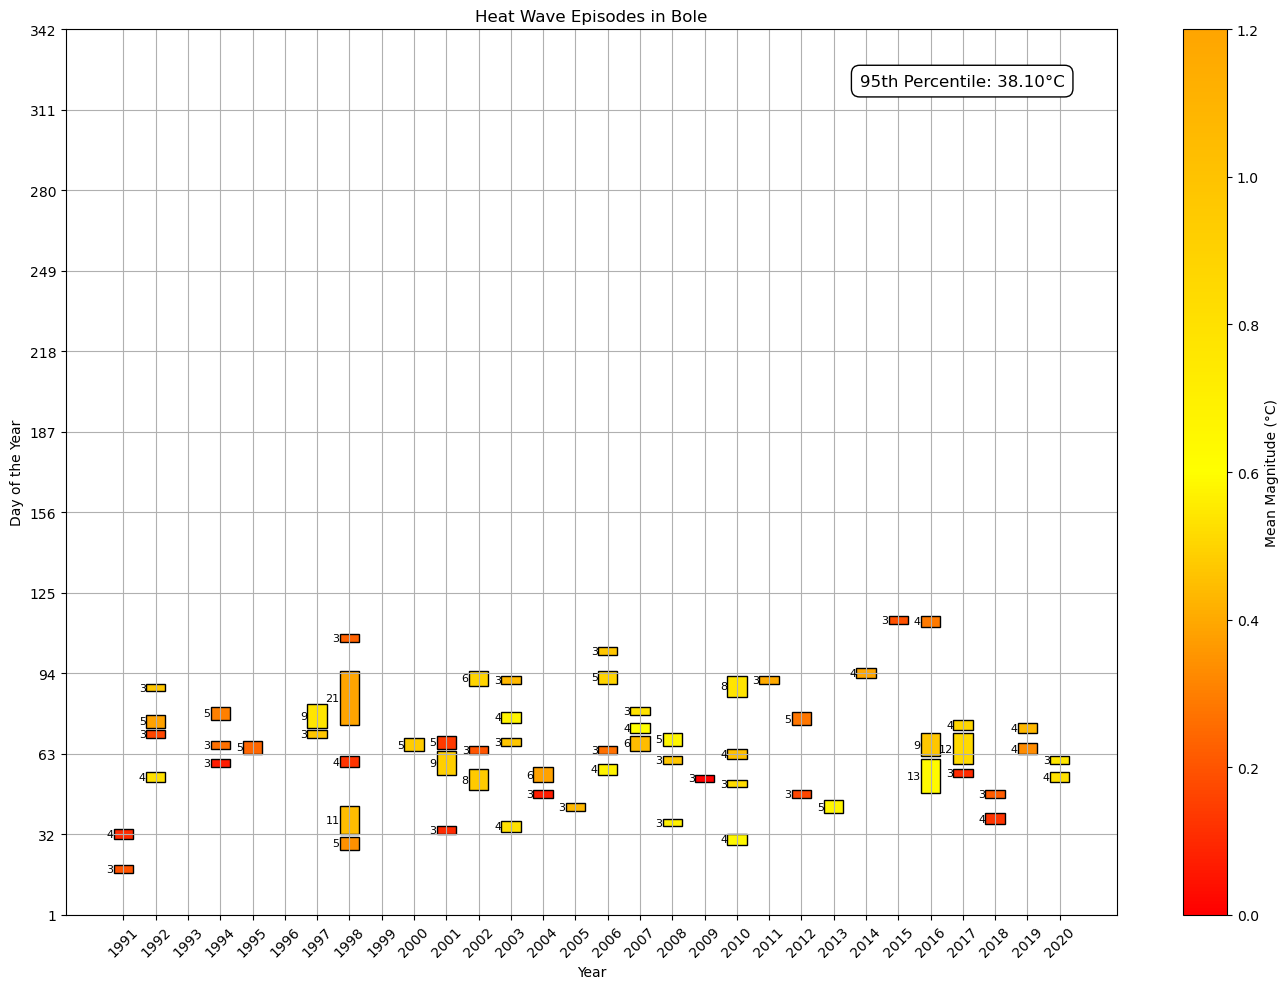

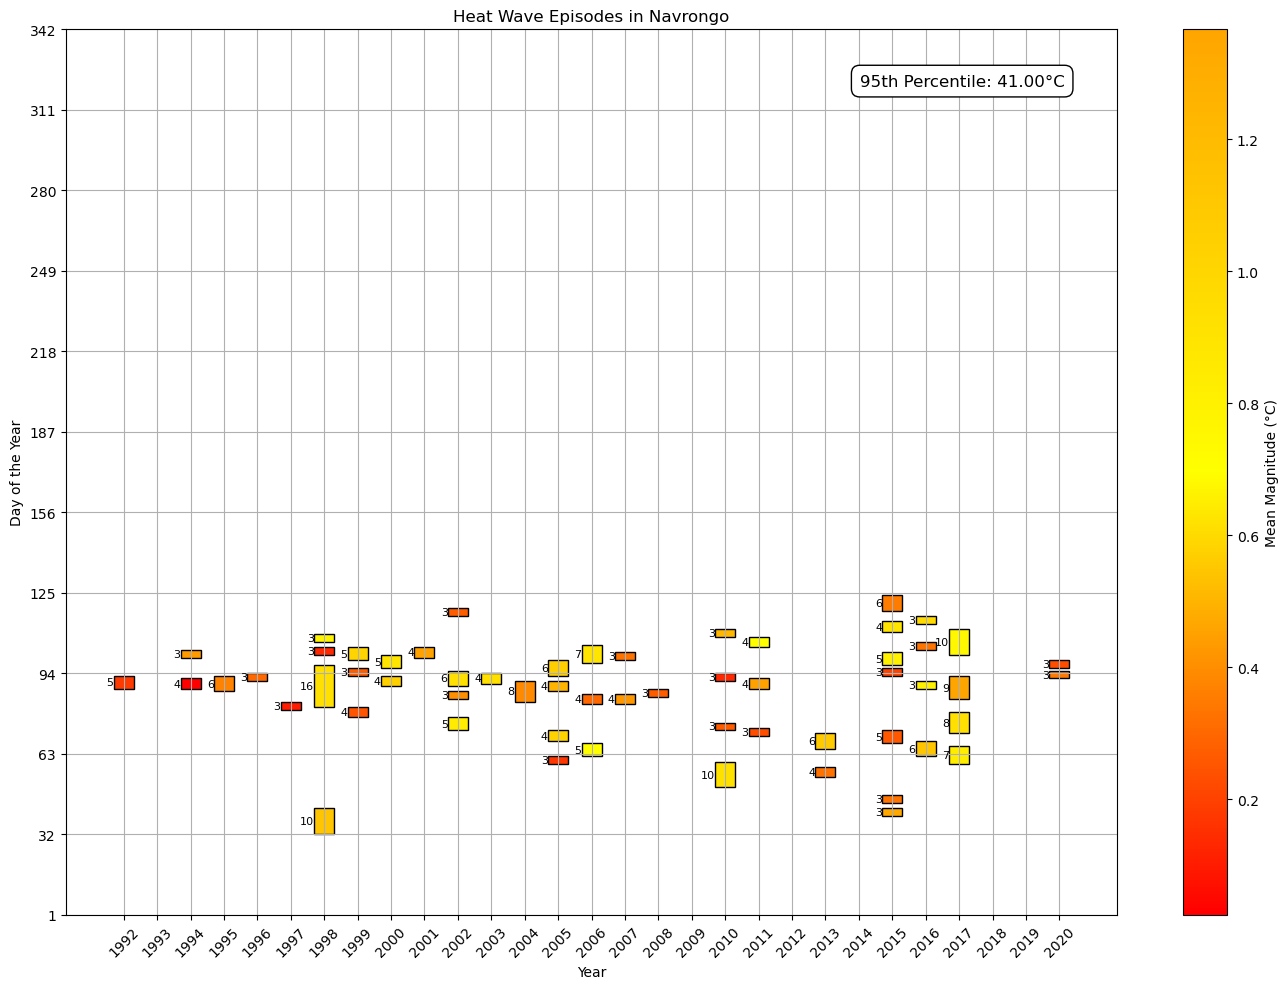

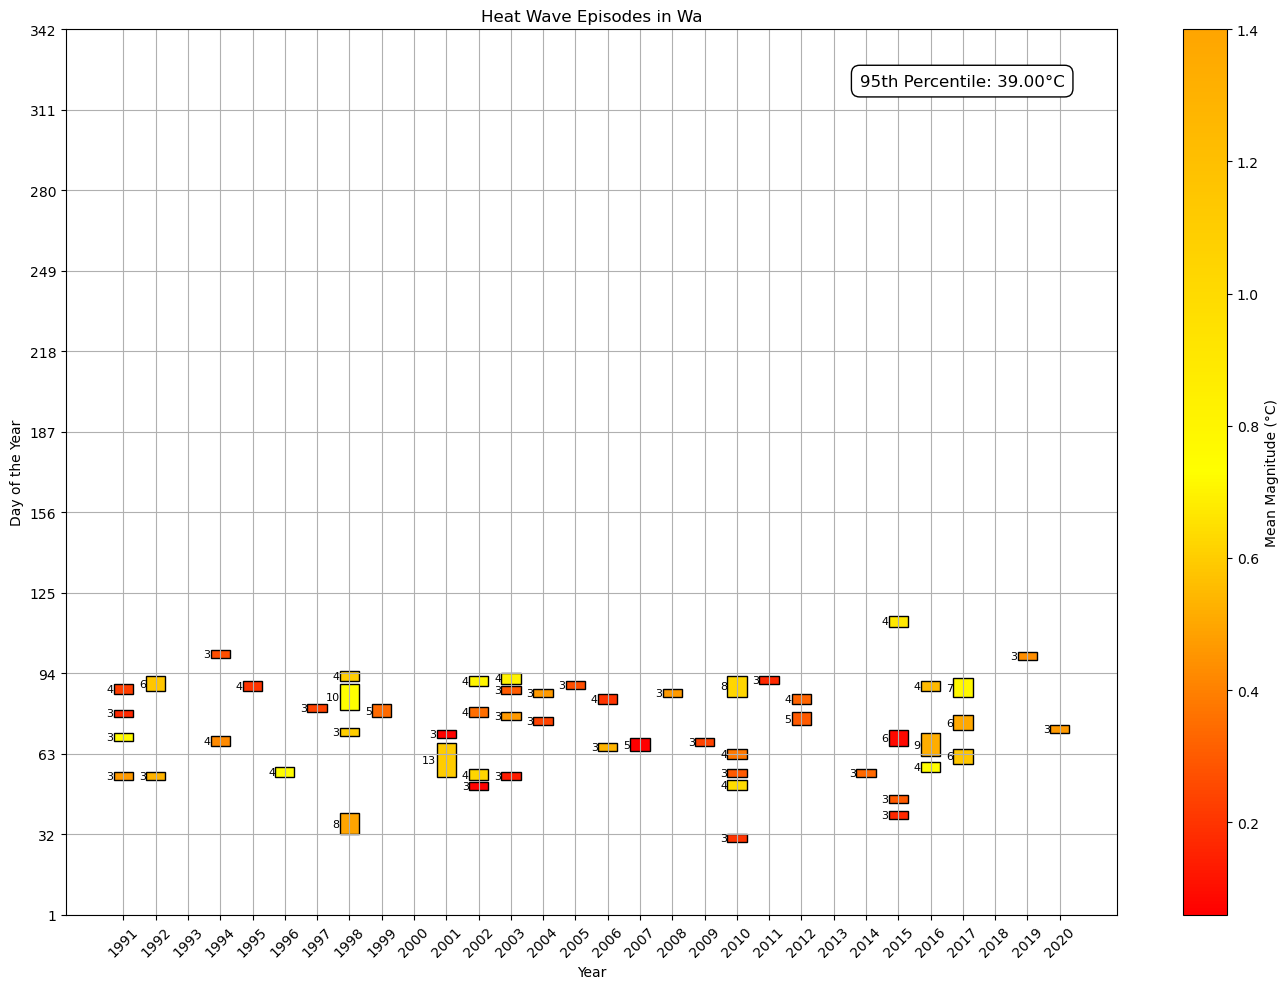

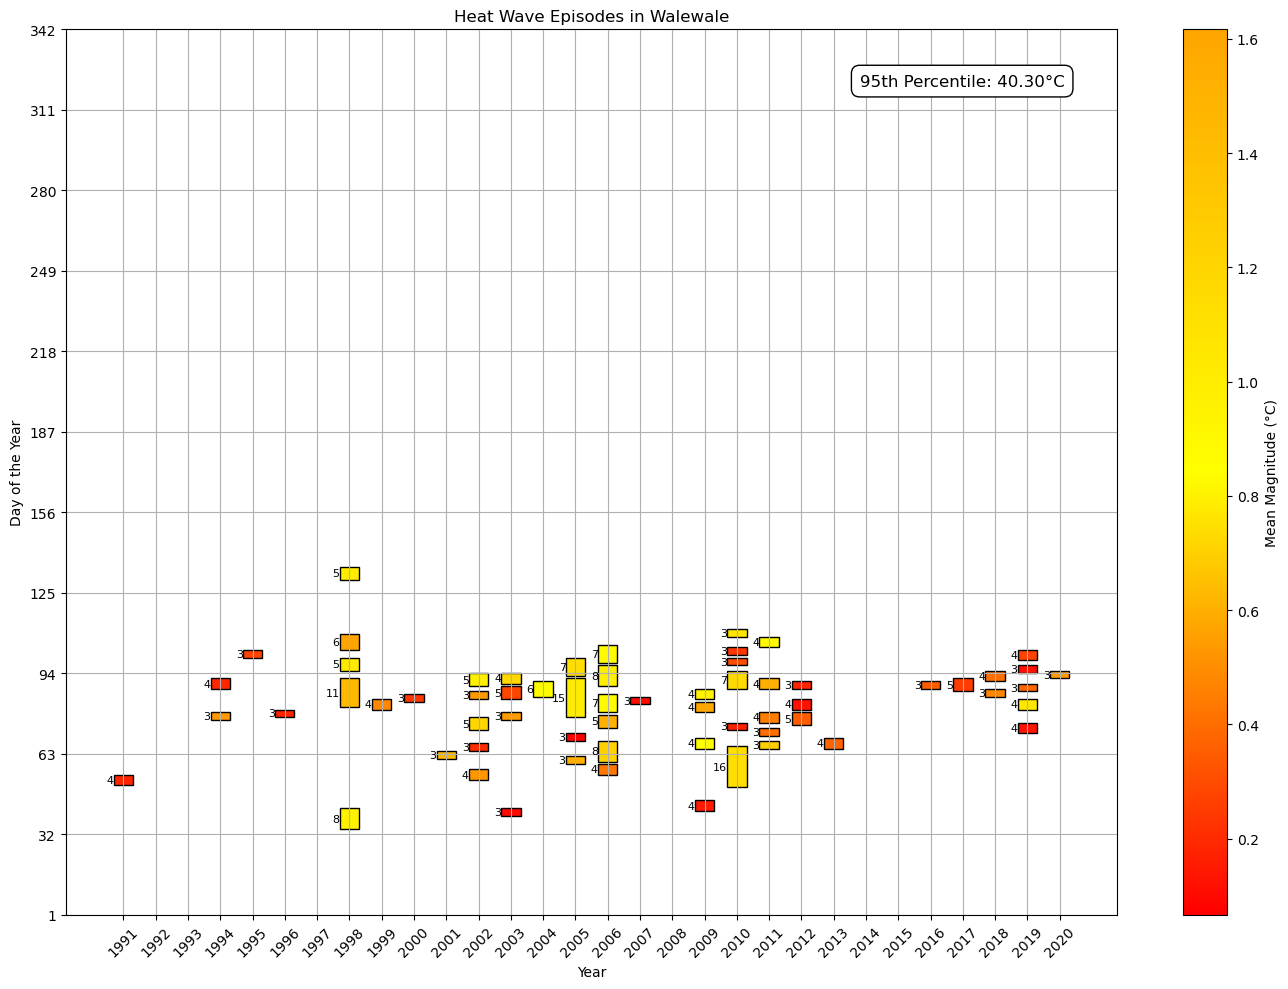

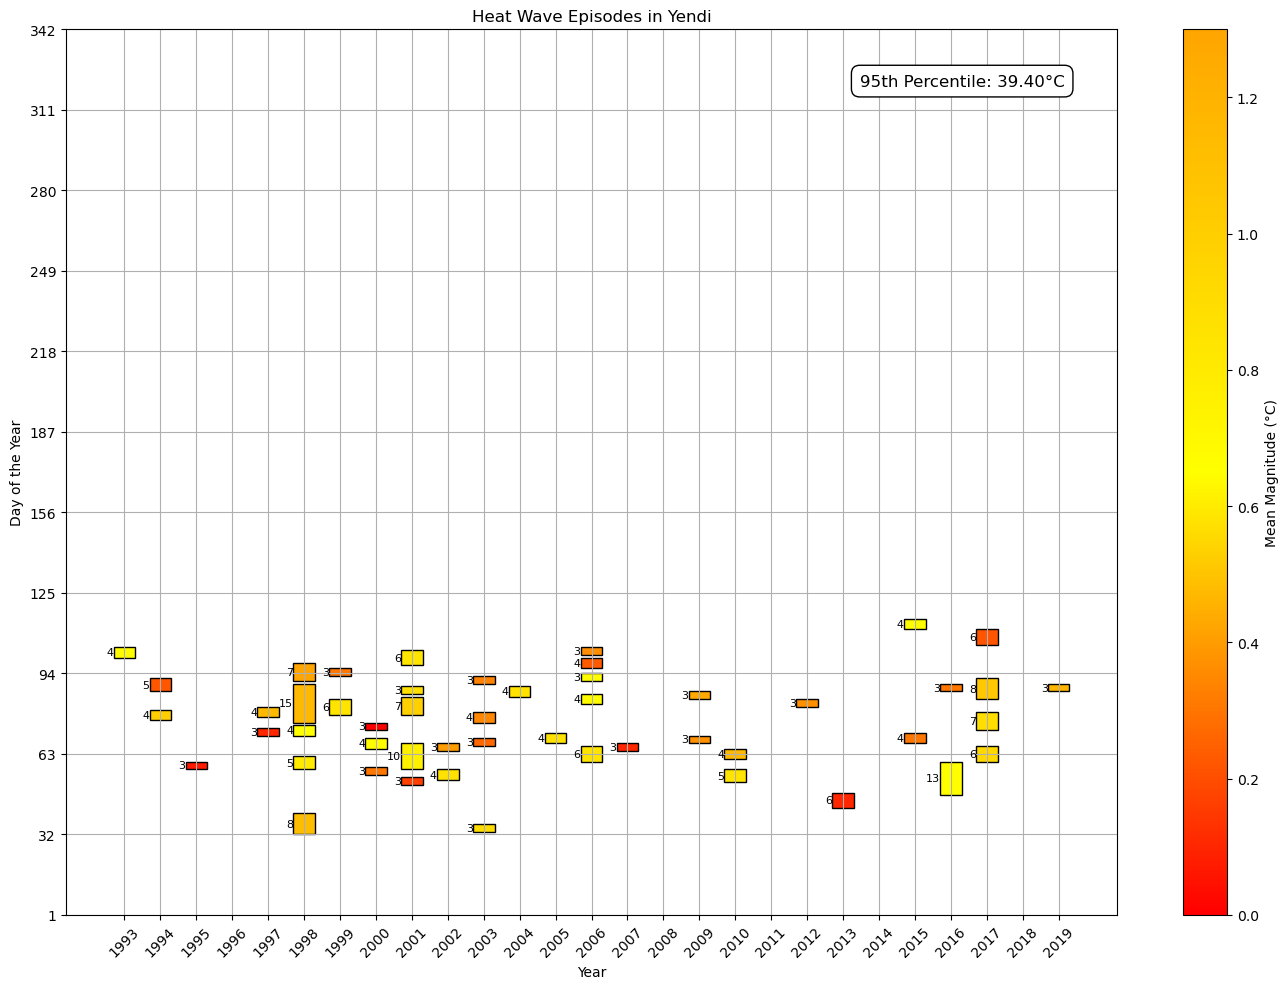

<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# Loading the data
Bole = pd.read_csv('Bole_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Navrongo = pd.read_csv('Navrongo_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Wa = pd.read_csv('Wa_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Walewale = pd.read_csv('Walewale_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]
Yendi = pd.read_csv('Yendi_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]

# Storing data in a dictionary for easier processing
data = {
    'Bole': Bole,
    'Navrongo': Navrongo,
    'Wa': Wa,
    'Walewale': Walewale,
    'Yendi': Yendi
}

# Calculating the 95th percentile for each dataset
percentiles = {location: np.percentile(df['max_temperature'], 95) for location, df in data.items()}

# Filtering days exceeding the 95th percentile for each dataset
for location, df in data.items():
    df['above_95th'] = df['max_temperature'] > percentiles[location]

# Defining the function to find consecutive days above the 95th percentile and extract episodes
def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    df = df.dropna(subset=['date'])  # Dropping rows where date parsing failed

    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    df['episode_id'] = (df['above_95th'] & (df['consecutive'] == 1)).cumsum()

    # Identifying the start and end of each episode
    episode_starts = df[df['consecutive'] == 1].reset_index()
    episode_ends = df[df['consecutive'] == df['consecutive'].groupby(df['episode_id']).transform('max')].reset_index()

    # Merging start and end dates
    episodes = pd.merge(episode_starts, episode_ends, on='episode_id', suffixes=('_start', '_end'))
    episodes = episodes[episodes['consecutive_end'] >= 3]

    return episodes[['date_start', 'date_end', 'max_temperature_start', 'max_temperature_end', 'episode_id']]

# Getting the episodes for each location
episodes = {location: filter_consecutive_days(df) for location, df in data.items()}

# Defining the function to calculate the mean magnitude for each episode
def calculate_episode_magnitude(df, original_df):
    magnitudes = []
    for _, episode in df.iterrows():
        episode_df = original_df[(original_df['date'] >= episode['date_start']) & (original_df['date'] <= episode['date_end'])]
        daily_magnitudes = episode_df['max_temperature'] - episode_df['max_temperature'].min()
        mean_magnitude = daily_magnitudes.mean()
        magnitudes.append(mean_magnitude)
    df['mean_magnitude'] = magnitudes
    return df

# Calculating the mean magnitude for each episode
for location in data.keys():
    episodes[location] = calculate_episode_magnitude(episodes[location], data[location])

# Creating a colormap 
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["red", "yellow", "orange"])

# Defining the plotting function for heat wave episodes with vertical bars and dates on the y-axis
def plot_heat_wave_episodes(episodes_df, location_name, percentile):
    # Initializing lists to store episode data
    episodes = []

    # Flattening the start and end dates into a single list of dictionaries
    for _, episode in episodes_df.iterrows():
        episodes.append({
            'date_start': episode['date_start'],
            'date_end': episode['date_end'],
            'mean_magnitude': episode['mean_magnitude'],
            'duration': (episode['date_end'] - episode['date_start']).days + 1
        })

    # Creating DataFrame from episodes list
    episodes_df = pd.DataFrame(episodes)

    # Sorting the episodes by the start date to ensure chronological order
    episodes_df = episodes_df.sort_values(by='date_start')

    # Creating a normalized colormap based on the mean magnitude
    norm = Normalize(vmin=episodes_df['mean_magnitude'].min(), vmax=episodes_df['mean_magnitude'].max())

    # Plotting the data as bars from start date to end date
    fig, ax = plt.subplots(figsize=(14, 10))

    for idx, episode in episodes_df.iterrows():
        color = cmap(norm(episode['mean_magnitude']))

        # Determining the y-position for the episode
        y_pos = episode['date_start'].timetuple().tm_yday

        # Plotting the episode bar
        ax.bar(episode['date_start'].year, episode['duration'], bottom=y_pos, color=color, width=0.6, edgecolor='black')

        # Annotating the number of days in front of the bar
        ax.text(episode['date_start'].year - 0.3, y_pos + episode['duration'] / 2, f'{episode["duration"]}', ha='right', va='center', color='black', fontsize=8)

    # Annotating the percentile value on the plot
    ax.annotate(f'95th Percentile: {percentile:.2f}°C', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    # Setting the x-axis to display the years in order
    ax.set_xticks(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1))
    ax.set_xticklabels(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1), rotation=45)

    # Setting the y-axis ticks and labels to handle leap years
    y_ticks = []
    y_labels = []
    for day in range(1, 366, 31):
        y_ticks.append(day)
        y_labels.append(f'{day}')
        if day == 31:
            y_ticks.append(day + 28)  # February in non-leap years
            y_labels.append(f'{day + 28}')
        elif day == 62:
            y_ticks.append(day + 29)  # February in leap years
            y_labels.append(f'{day + 29}')

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    ax.set_xlabel('Year')
    ax.set_ylabel('Day of the Year')
    ax.set_title(f'Heat Wave Episodes in {location_name}')

    # Creating a ScalarMappable for the Colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # No data is needed for mapping

    # Adding the Colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Mean Magnitude (°C)')

    plt.grid(True)
    plt.tight_layout()

    # Saving the figure as an image file
    plt.savefig(f'heat_wave_episodes_{location_name}.png')
    plt.show()

# Example usage:
# Assuming Bole_episodes, Navrongo_episodes, etc., are pre-defined DataFrames with the necessary columns.
plot_heat_wave_episodes(episodes['Bole'], 'Bole', percentiles['Bole'])
plot_heat_wave_episodes(episodes['Navrongo'], 'Navrongo', percentiles['Navrongo'])
plot_heat_wave_episodes(episodes['Wa'], 'Wa', percentiles['Wa'])
plot_heat_wave_episodes(episodes['Walewale'], 'Walewale', percentiles['Walewale'])
plot_heat_wave_episodes(episodes['Yendi'], 'Yendi', percentiles['Yendi'])
plt.savefig('plot.png')



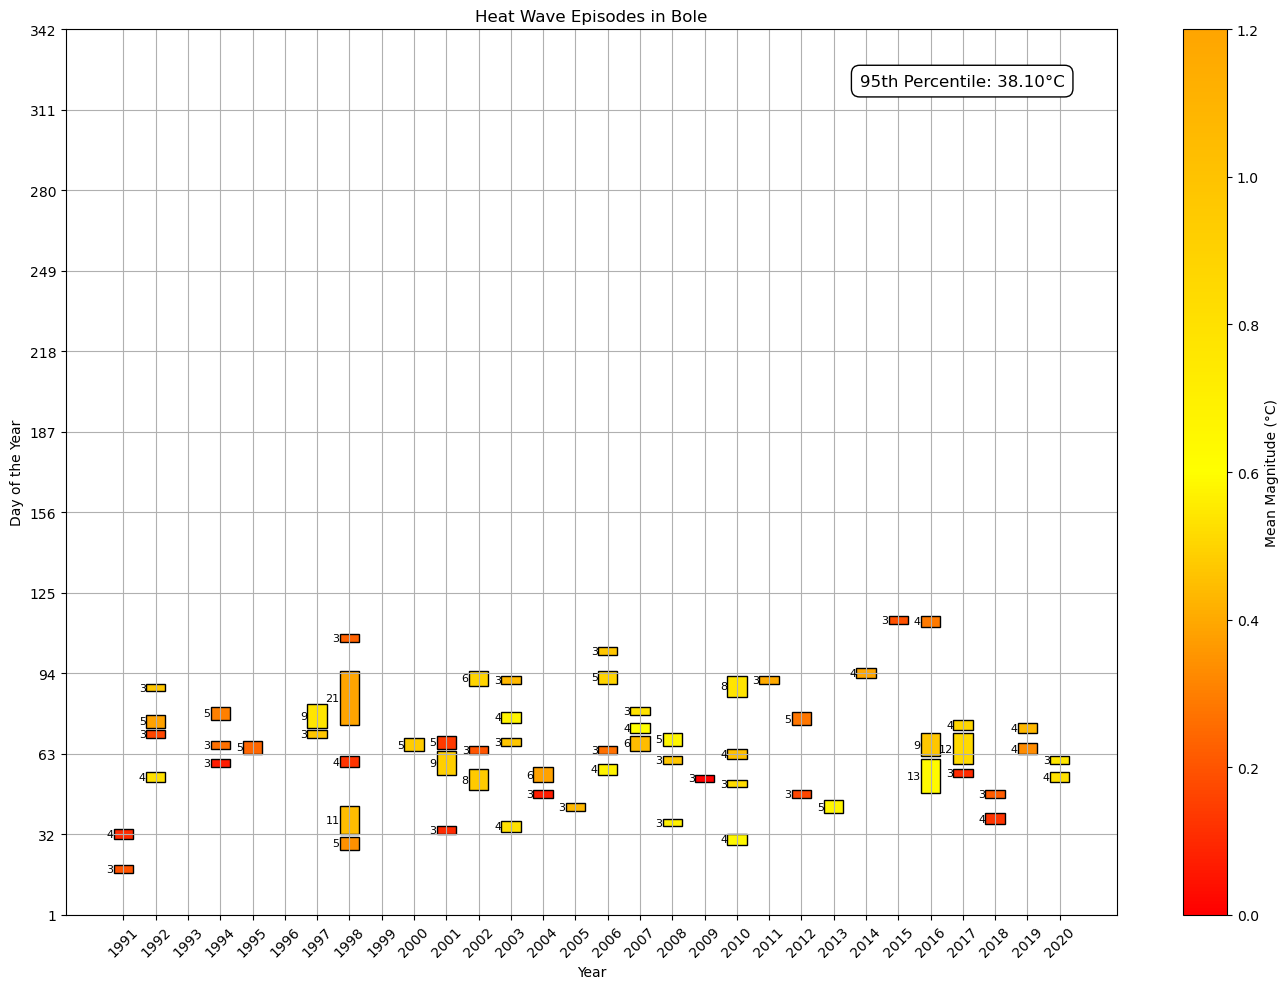

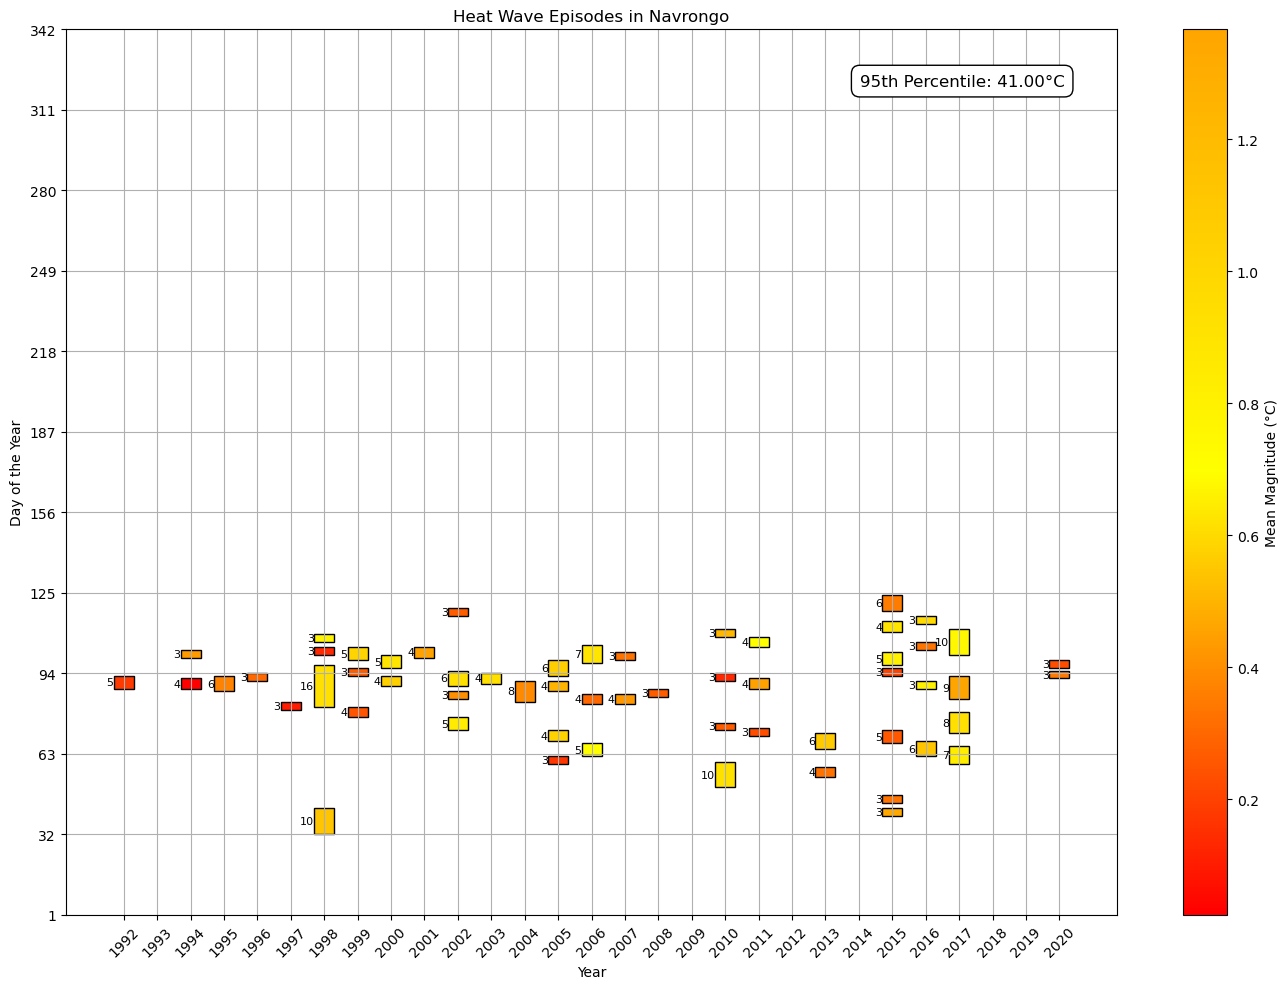

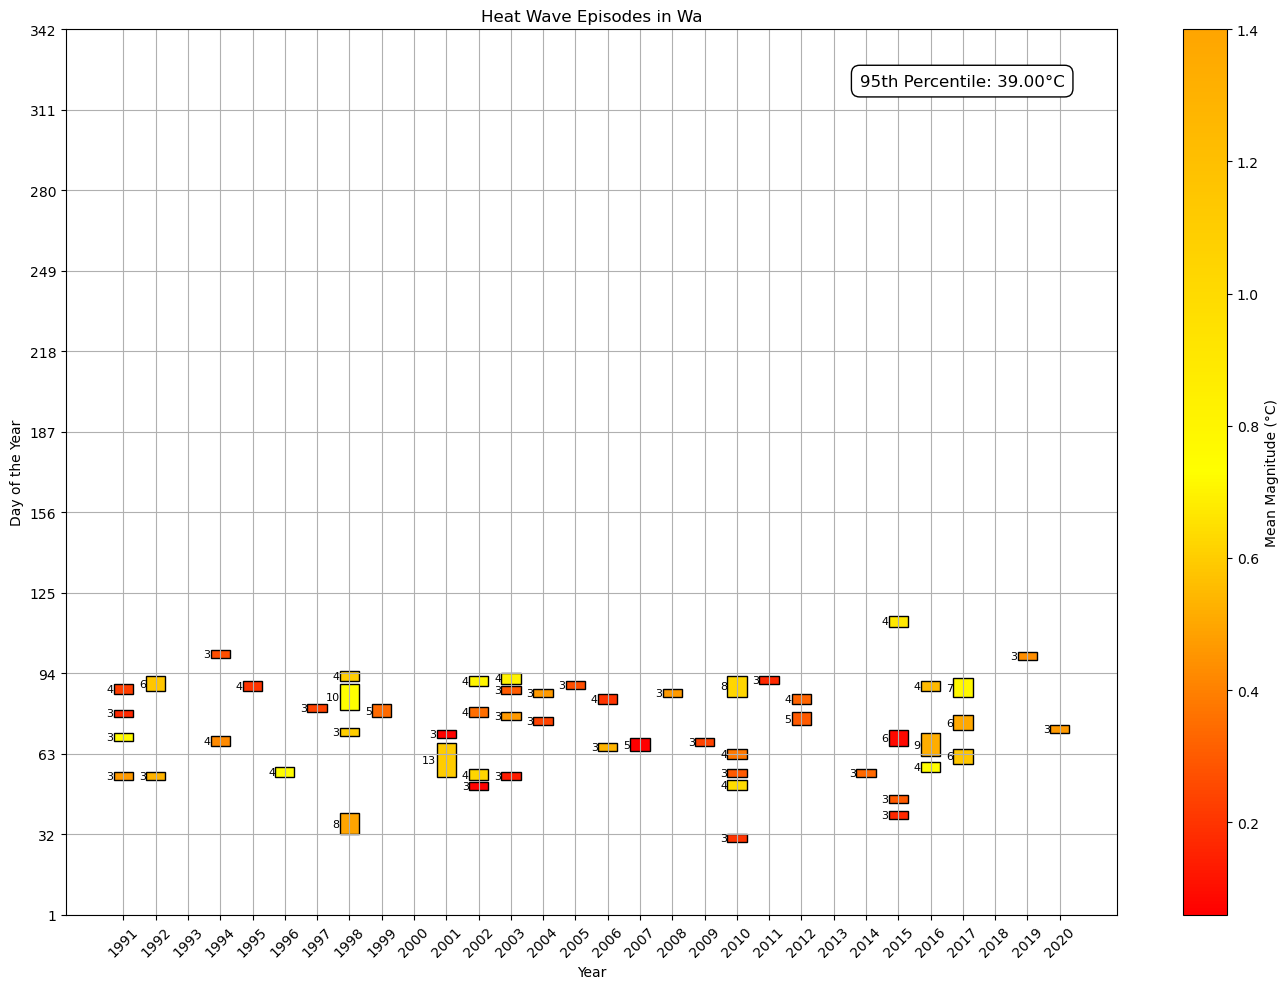

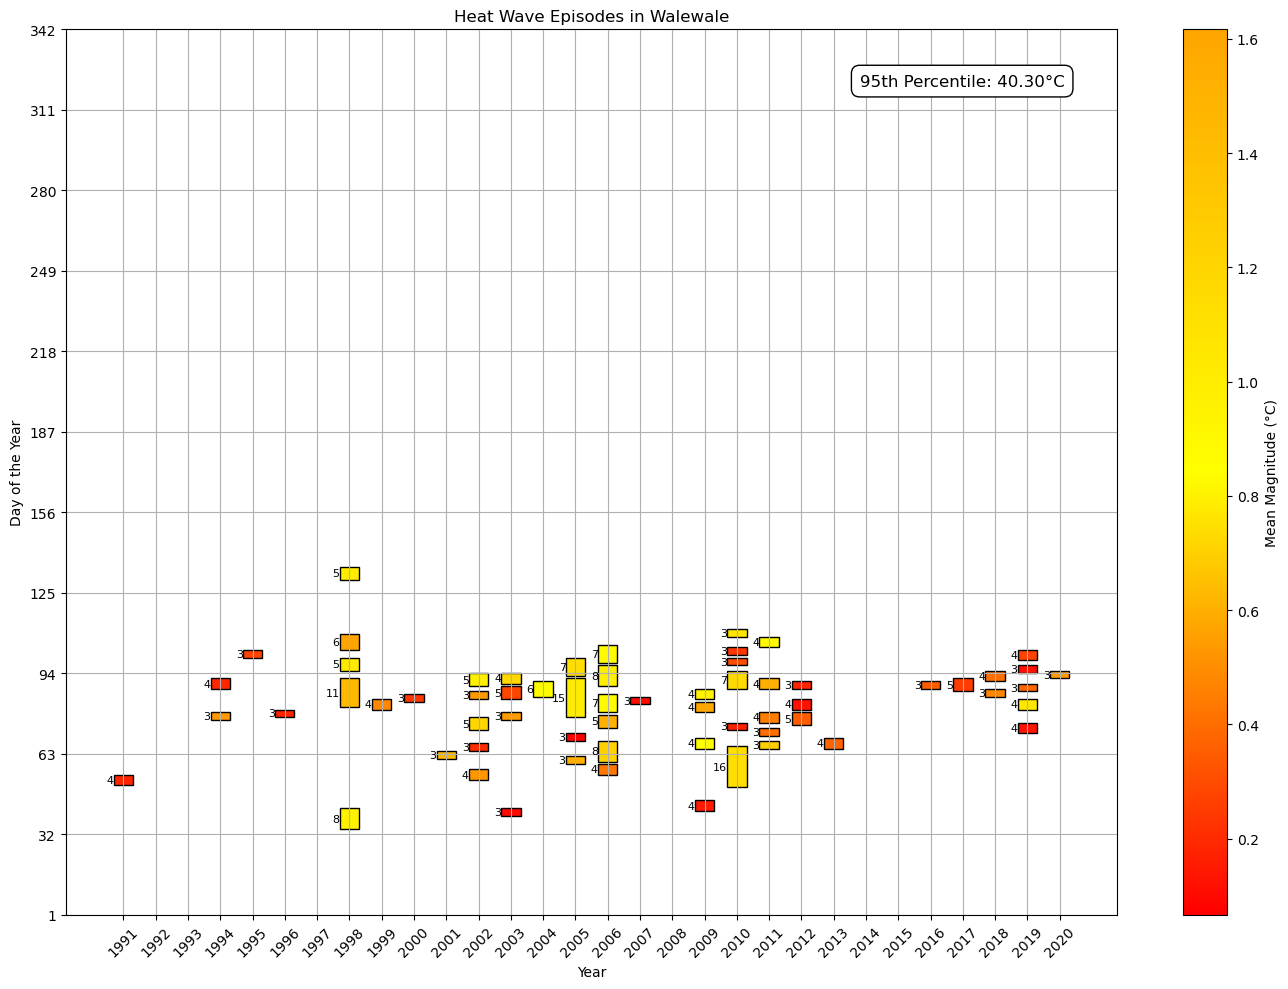

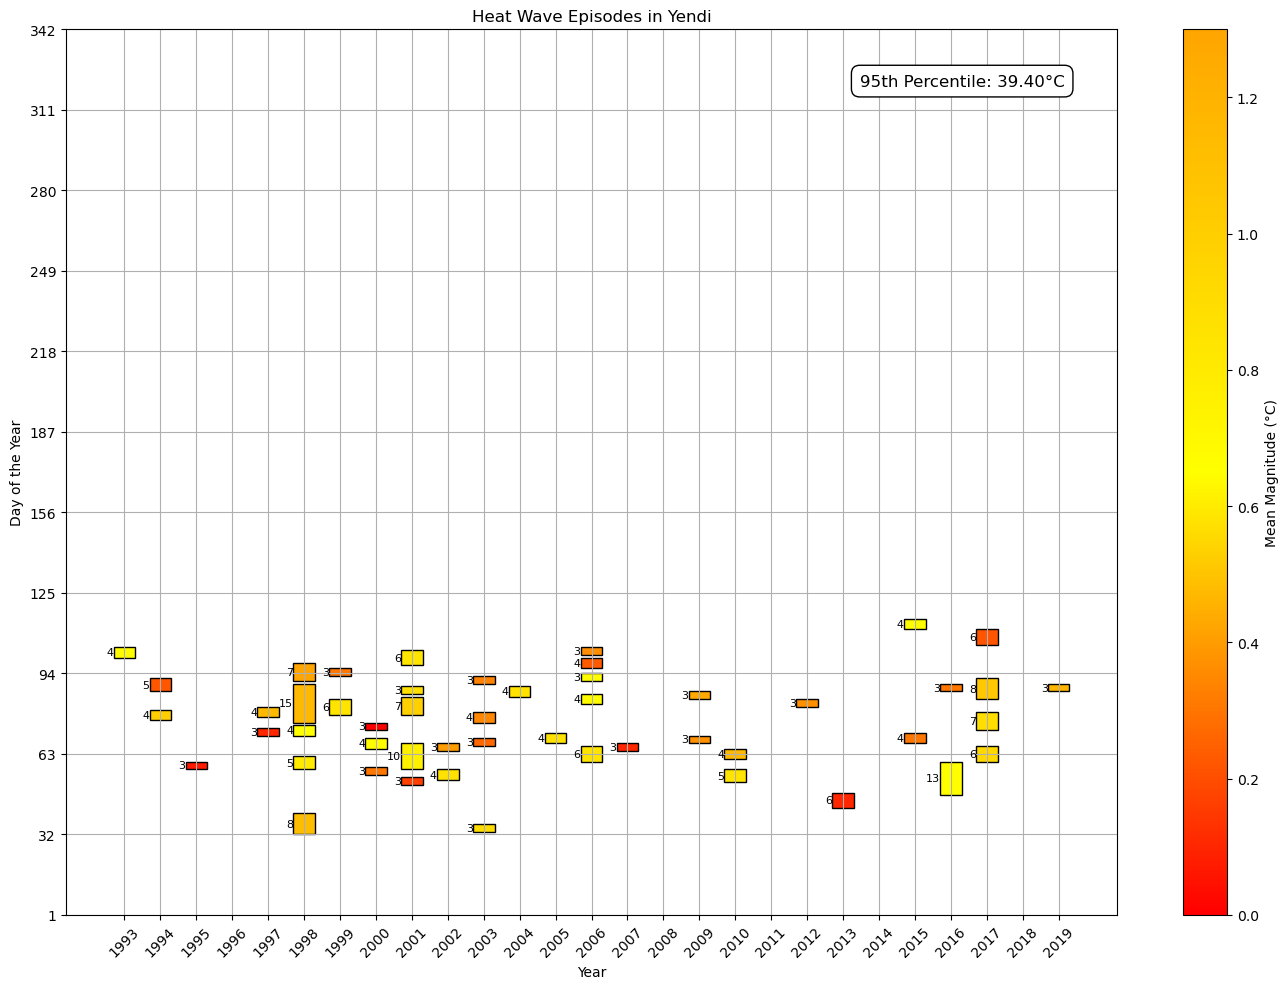

<Figure size 640x480 with 0 Axes>

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# Loading the data for each location
locations = ['Bole', 'Navrongo', 'Wa', 'Walewale', 'Yendi']
data = {}
for location in locations:
    data[location] = pd.read_csv(f'{location}_1960_2020_dTx_cgf.txt', delimiter=r"\s+", header=None, names=["Year", "Month", "Day", "max_temperature"]).iloc[11323:22281]

# Calculating the 95th percentile for each dataset
percentiles = {location: np.percentile(df['max_temperature'], 95) for location, df in data.items()}

# Filtering days exceeding the 95th percentile for each dataset
for location, df in data.items():
    df['above_95th'] = df['max_temperature'] > percentiles[location]

# Defining the function to find consecutive days above the 95th percentile and extract episodes
def filter_consecutive_days(df):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    df = df.dropna(subset=['date'])  # Dropping rows where date parsing failed

    df['consecutive'] = df['above_95th'].astype(int).groupby((df['above_95th'] != df['above_95th'].shift()).cumsum()).cumsum()
    df['episode_id'] = (df['above_95th'] & (df['consecutive'] == 1)).cumsum()

    # Identifying the start and end of each episode
    episode_starts = df[df['consecutive'] == 1].reset_index()
    episode_ends = df[df['consecutive'] == df['consecutive'].groupby(df['episode_id']).transform('max')].reset_index()

    # Merging start and end dates
    episodes = pd.merge(episode_starts, episode_ends, on='episode_id', suffixes=('_start', '_end'))
    episodes = episodes[episodes['consecutive_end'] >= 3]

    return episodes[['date_start', 'date_end', 'max_temperature_start', 'max_temperature_end', 'episode_id']]

# Getting the episodes for each location
episodes = {location: filter_consecutive_days(df) for location, df in data.items()}

# Defining the function to calculate the mean magnitude for each episode
def calculate_episode_magnitude(df, original_df):
    magnitudes = []
    for _, episode in df.iterrows():
        episode_df = original_df[(original_df['date'] >= episode['date_start']) & (original_df['date'] <= episode['date_end'])]
        daily_magnitudes = episode_df['max_temperature'] - episode_df['max_temperature'].min()
        mean_magnitude = daily_magnitudes.mean()
        magnitudes.append(mean_magnitude)
    df['mean_magnitude'] = magnitudes
    return df

# Calculating the mean magnitude for each episode
for location in locations:
    episodes[location] = calculate_episode_magnitude(episodes[location], data[location])

# Creating a colormap 
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["red", "yellow", "orange"])

# Defining the plotting function for heat wave episodes with vertical bars and dates on the y-axis
def plot_heat_wave_episodes(episodes_df, location_name, percentile):
    # Initializing lists to store episode data
    episodes = []

    # Flattening the start and end dates into a single list of dictionaries
    for _, episode in episodes_df.iterrows():
        episodes.append({
            'date_start': episode['date_start'],
            'date_end': episode['date_end'],
            'mean_magnitude': episode['mean_magnitude'],
            'duration': (episode['date_end'] - episode['date_start']).days + 1
        })

    # Creating DataFrame from episodes list
    episodes_df = pd.DataFrame(episodes)

    # Sorting the episodes by the start date to ensure chronological order
    episodes_df = episodes_df.sort_values(by='date_start')

    # Creating a normalized colormap based on the mean magnitude
    norm = Normalize(vmin=episodes_df['mean_magnitude'].min(), vmax=episodes_df['mean_magnitude'].max())

    # Plotting the data as bars from start date to end date
    fig, ax = plt.subplots(figsize=(14, 10))

    for idx, episode in episodes_df.iterrows():
        color = cmap(norm(episode['mean_magnitude']))

        # Determining the y-position for the episode
        y_pos = episode['date_start'].timetuple().tm_yday

        # Plotting the episode bar
        ax.bar(episode['date_start'].year, episode['duration'], bottom=y_pos, color=color, width=0.6, edgecolor='black')

        # Annotating the number of days in front of the bar
        ax.text(episode['date_start'].year - 0.3, y_pos + episode['duration'] / 2, f'{episode["duration"]}', ha='right', va='center', color='black', fontsize=8)

    # Annotating the percentile value on the plot
    ax.annotate(f'95th Percentile: {percentile:.2f}°C', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    # Setting the x-axis to display the years in order
    ax.set_xticks(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1))
    ax.set_xticklabels(np.arange(episodes_df['date_start'].dt.year.min(), episodes_df['date_start'].dt.year.max() + 1), rotation=45)

    # Setting the y-axis ticks and labels to handle leap years
    y_ticks = []
    y_labels = []
    for day in range(1, 366, 31):
        y_ticks.append(day)
        y_labels.append(f'{day}')
        if day == 31:
            y_ticks.append(day + 28)  # February in non-leap years
            y_labels.append(f'{day + 28}')
        elif day == 62:
            y_ticks.append(day + 29)  # February in leap years
            y_labels.append(f'{day + 29}')

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    ax.set_xlabel('Year')
    ax.set_ylabel('Day of the Year')
    ax.set_title(f'Heat Wave Episodes in {location_name}')

    # Creating a ScalarMappable for the Colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # No data is needed for mapping

    # Adding the Colorbar
    cbar = fig.colorbar(sm, ax=ax, label='Mean Magnitude (°C)')

    plt.grid(True)
    plt.tight_layout()

    # Saving the figure as an image file
    plt.savefig(f'heat_wave_episodes_{location_name}.png')
    plt.show()

# Example usage:
# Assuming Bole_episodes, Navrongo_episodes, etc., are pre-defined DataFrames with the necessary columns.
plot_heat_wave_episodes(episodes['Bole'], 'Bole', percentiles['Bole'])
plot_heat_wave_episodes(episodes['Navrongo'], 'Navrongo', percentiles['Navrongo'])
plot_heat_wave_episodes(episodes['Wa'], 'Wa', percentiles['Wa'])
plot_heat_wave_episodes(episodes['Walewale'], 'Walewale', percentiles['Walewale'])
plot_heat_wave_episodes(episodes['Yendi'], 'Yendi', percentiles['Yendi'])
plt.savefig('plot.png')

